<!--BOOK_INFORMATION-->
<img style="float: right; width: 100px" src="https://raw.github.com/pyomeca/design/master/logo/logo_cropped.svg?sanitize=true">

<font size="+2">Pyosim in the cloud</font>

<font size="+1">with [pyomeca](https://github.com/pyomeca/pyom</font>a)

Romain Martinez (martinez.staps@gmail.com | [GitHub](https://github.com/romainmartinez))


<!--NAVIGATION-->
< [Analyses](02.00-men-women.ipynb) | [Contents](Index.ipynb) | [Joint reactions](02.02-joint-reactions.ipynb) >

# Muscle activations & muscles forces

In [1]:
from pathlib import Path

import yaml
import numpy as np
import pandas as pd
import altair as alt
from pyosim import Conf
from pyomeca import Analogs3d
import spm1d
import matplotlib.pyplot as plt

from src.util import (
    parse_conditions,
    condition_counter,
    random_balanced_design,
    get_spm_cluster,
    ridge_plot,
    describe_clusters
)

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
alt.data_transformers.enable("json")
# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
aws_conf = yaml.safe_load(open("../conf.yml"))

conf = Conf(project_path=aws_conf["path"]["project"]["local"])
conf.check_confs()

Project loaded
Configuration file loaded


## Reading files

In [4]:
suffix = "_StaticOptimization_activation"
# suffix = "_StaticOptimization_force"

act = (
    pd.concat(
        [
            Analogs3d.from_sto(ifile)
            .time_normalization()
            .to_dataframe()
            .assign(filename=ifile.stem)
            for ifile in conf.project_path.glob(f"*/3_static_optimization/*{suffix}*")
        ]
    )
    .pipe(parse_conditions, suffix="wu_", prefix=suffix)
    .reset_index()
    .assign(index=lambda x: x["index"] / 100)
    .query("mass != 18")
)

act.head()

,index,LVS,TRP1,TRP2,TRP3,TRP4,RMN,RMJ1,RMJ2,SRA1,...,AC3,GH1,GH2,GH3,filename,participant,men,height,mass,n_trial
0,0.00,0.093195,0.194355,0.083498,0.055261,0.045271,0.105586,0.029389,0.010329,0.066250,...,0.008311,-0.026867,0.022399,0.020511,VerCF12H2_3,verc,0,2,12,3
1,0.01,0.129131,0.309957,0.134745,0.094603,0.057375,0.152283,0.032945,0.010123,0.011763,...,0.014365,-0.036946,0.028573,0.033740,VerCF12H2_3,verc,0,2,12,3
2,0.02,0.203825,0.365121,0.189626,0.139795,0.095451,0.228780,0.037695,0.010086,0.010040,...,0.026711,-0.051659,0.038459,0.049153,VerCF12H2_3,verc,0,2,12,3
3,0.03,0.327648,0.479070,0.278189,0.204747,0.171899,0.349120,0.051687,0.010075,0.010031,...,0.044441,-0.076361,0.055289,0.071399,VerCF12H2_3,verc,0,2,12,3
4,0.04,0.396332,0.566834,0.359928,0.260211,0.224858,0.410618,0.050651,0.010039,0.010029,...,0.057666,-0.097264,0.071052,0.086335,VerCF12H2_3,verc,0,2,12,3


## Clean data

### Balance dataset

By randomly taking the minimum number of trials for each condition

In [5]:
to_bold = lambda x: "\033[1m" + x + "\033[0m"

print(to_bold("Initial"))
condition_counter(act)

Initial
n. participants: 37
----------
men
0    110
1    101
----------
height
2    211
----------
mass
6     106
12    105
----------
men  mass
0    6       54
     12      56
1    6       52
     12      49
----------


In [6]:
balanced_trials = random_balanced_design(
    act, ["men", "mass"], random_state=RANDOM_SEED
)["filename"].tolist()
act = act.query("filename == @balanced_trials")

print(to_bold("Balanced:"))
condition_counter(act)

Balanced:
n. participants: 37
----------
men
0    98
1    98
----------
height
2    196
----------
mass
6     98
12    98
----------
men  mass
0    6       49
     12      49
1    6       49
     12      49
----------


### Drop unwanted variables

In [7]:
id_vars = ["filename", "participant", "men", "height", "mass", "n_trial", "index"]
act_melt = act.melt(id_vars=id_vars)
act_melt.head()

,filename,participant,men,height,mass,n_trial,index,variable,value
0,VerCF12H2_3,verc,0,2,12,3,0.00,LVS,0.093195
1,VerCF12H2_3,verc,0,2,12,3,0.01,LVS,0.129131
2,VerCF12H2_3,verc,0,2,12,3,0.02,LVS,0.203825
3,VerCF12H2_3,verc,0,2,12,3,0.03,LVS,0.327648
4,VerCF12H2_3,verc,0,2,12,3,0.04,LVS,0.396332


In [8]:
blacklist = ["AC1", "AC2", "AC3", "SC1", "SC2", "SC3", "GH1", "GH2", "GH3"]
blacklist = blacklist + [
    "box_Rx",
    "box_Ry",
    "box_Rz",
    "box_Tx",
    "box_Ty",
    "box_Tz",
    "thorax_Tx",
    "thorax_Ty",
    "thorax_Tz",
    "thorax_Rx",
    "thorax_Ry",
    "thorax_Rz",
    "elbow_Rz",
    "elbow_Ry",
    "hand_Rz",
    "hand_Rx",
    "hand_r_s2h_Fx",
    "hand_r_s2h_Fy",
    "hand_r_s2h_Fz",
    "hand_r_s2h_Tx",
    "hand_r_s2h_Ty",
    "hand_r_s2h_Tz",
]

act_melt = act_melt.query("variable != @blacklist")

## Description

In [9]:
print(
    f"value > 0.999 = {act_melt.query('value > 0.999').shape[0] / act_melt.shape[0] * 100:.2f}%"
)

value > 0.999 = 5.40%


In [10]:
x = act_melt.groupby(["variable", "index"])["value"].mean().reset_index()
x.head()

,variable,index,value
0,CORB,0.00,0.013195
1,CORB,0.01,0.011520
2,CORB,0.02,0.011491
3,CORB,0.03,0.011129
4,CORB,0.04,0.010922


In [11]:
act_melt.groupby(["variable", "index"])["value"].mean().reset_index().groupby(
    "variable"
)["value"].apply(lambda x: (x < 50).sum()).sort_values()

variable
CORB         101
bic_b        101
TRP4         101
TRP3         101
TRP2         101
TRP1         101
TMIN         101
TMAJ         101
SUPSP        101
SUBSC        101
SRA3         101
SRA2         101
SRA1         101
bic_l        101
SBCL         101
RMJ2         101
RMJ1         101
PMN          101
PECM3        101
PECM2        101
PECM1        101
LVS          101
LAT          101
INFSP        101
DELT3        101
DELT2        101
DELT1        101
RMN          101
tric_long    101
Name: value, dtype: int64

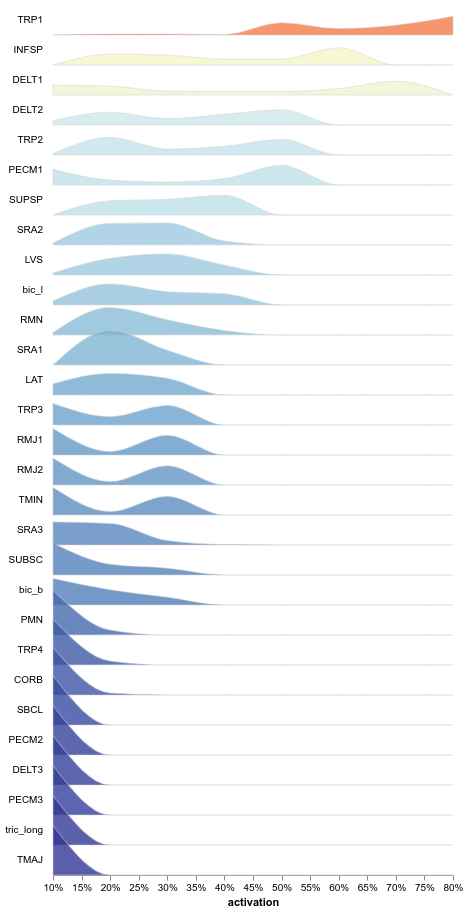

In [12]:
ridge_plot(
    act_melt.groupby(["variable", "index"])["value"].mean().reset_index(),
    value="value",
    groupby="variable",
    sort=act_melt.groupby(["variable"])["value"]
    .mean()
    .sort_values(ascending=False)
    .index.to_list(),
)

## $\sum$activation

In [13]:
sum_act = act_melt.groupby(id_vars)["value"].sum().reset_index()
sum_act.head()

,filename,participant,men,height,mass,n_trial,index,value
0,AimQF12H2_1,aimq,0,2,12,1,0.00,1.695294
1,AimQF12H2_1,aimq,0,2,12,1,0.01,1.409868
2,AimQF12H2_1,aimq,0,2,12,1,0.02,1.289427
3,AimQF12H2_1,aimq,0,2,12,1,0.03,1.375817
4,AimQF12H2_1,aimq,0,2,12,1,0.04,1.737254


In [14]:
y = (
    sum_act.assign(participant=lambda x: x["participant"].astype("category").cat.codes)
    .set_index(id_vars)
    .unstack()
)
y.head()

value                      \
index                                                0.00      0.01      0.02   
filename    participant men height mass n_trial                                 
AimQF12H2_1 0           0   2      12   1        1.695294  1.409868  1.289427   
AimQF12H2_2 0           0   2      12   2        2.019726  1.720067  1.252395   
AimQF12H2_3 0           0   2      12   3        1.301881  1.065941  1.030109   
AimQF6H2_1  0           0   2      6    1        1.693866  1.698144  1.745023   
AimQF6H2_2  0           0   2      6    2        1.714427  1.588956  1.494849   

                                                                               \
index                                                0.03      0.04      0.05   
filename    participant men height mass n_trial                                 
AimQF12H2_1 0           0   2      12   1        1.375817  1.737254  1.798957   
AimQF12H2_2 0           0   2      12   2        1.053381  0.970690  1.160973   
AimQF12H2_3 0           0   2      12   3        0.970541  1.104995  0.973718   
AimQF6H2_1  0           0   2      6    1        3.007067  3.615265  3.720659   
AimQF6H2_2  0           0   2      6    2        1.488349  2.535096  3.311375   

                                                                               \
index                                                0.06      0.07      0.08   
filename    participant men height mass n_trial                                 
AimQF12H2_1 0           0   2      12   1        1.517547  2.436055  4.769140   
AimQF12H2_2 0           0   2      12   2        1.382121  1.292042  2.596440   
AimQF12H2_3 0           0   2      12   3        0.757655  0.622779  4.309498   
AimQF6H2_1  0           0   2      6    1        3.750753  3.732351  3.501193   
AimQF6H2_2  0           0   2      6    2        3.617357  4.031807  4.029766   

                                                           ...            \
index                                                0.09  ...      0.91   
filename    participant men height mass n_trial            ...             
AimQF12H2_1 0           0   2      12   1        5.185554  ...  4.505662   
AimQF12H2_2 0           0   2      12   2        5.654903  ...  6.147710   
AimQF12H2_3 0           0   2      12   3        6.472112  ...  3.371128   
AimQF6H2_1  0           0   2      6    1        3.332644  ...  3.646579   
AimQF6H2_2  0           0   2      6    2        3.690903  ...  4.606439   

                                                                      \
index                                                0.92       0.93   
filename    participant men height mass n_trial                        
AimQF12H2_1 0           0   2      12   1        3.725569   3.646781   
AimQF12H2_2 0           0   2      12   2        6.002689   4.919254   
AimQF12H2_3 0           0   2      12   3        3.309512   3.155340   
AimQF6H2_1  0           0   2      6    1        2.990601   2.989856   
AimQF6H2_2  0           0   2      6    2        5.647857  10.776300   

                                                                       \
index                                                 0.94       0.95   
filename    participant men height mass n_trial                         
AimQF12H2_1 0           0   2      12   1         3.233824   3.125359   
AimQF12H2_2 0           0   2      12   2         4.048877   3.501027   
AimQF12H2_3 0           0   2      12   3         3.239597   3.146237   
AimQF6H2_1  0           0   2      6    1         2.517842   2.450383   
AimQF6H2_2  0           0   2      6    2        11.368522  11.561378   

                                                                       \
index                                                 0.96       0.97   
filename    participant men height mass n_trial                         
AimQF12H2_1 0           0   2      12   1         2.936307   2.358887   
AimQF12H2_2 0           0   2      12   2 

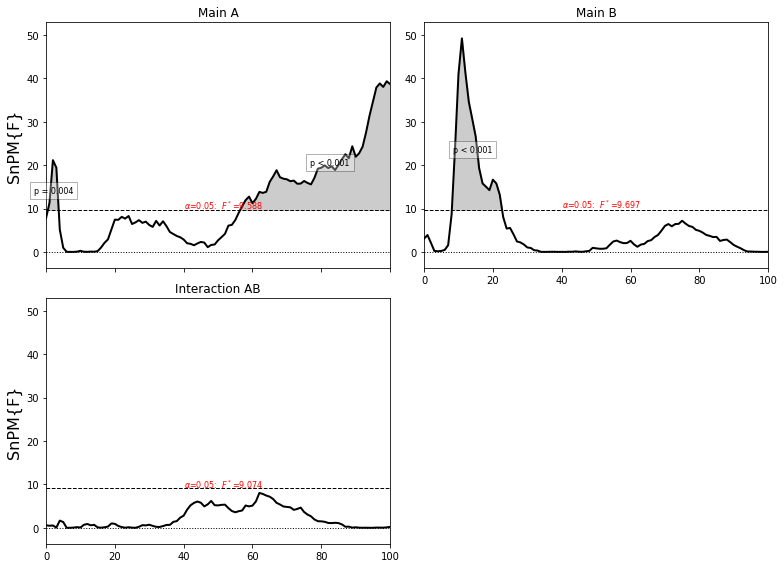

In [15]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    y.to_numpy(), A=y.index.get_level_values("men"), B=y.index.get_level_values("mass")
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [16]:
clusters = get_spm_cluster(
    spmi,
    labels={
        "Main A": "main sex",
        "Main B": "main mass",
        "Interaction AB": "interaction sex-mass",
    },
    mult=1 / y.shape[1],
)
clusters

,effect,p,start,end
0,main sex,0.00433333,0.00513589,0.0365314
1,main sex,0,0.558106,0.990099
2,main mass,0,0.0799315,0.224518


In [17]:
effect = {"main sex": "men", "main mass": "mass"}
clusters = describe_clusters(clusters, sum_act, effect)
clusters

,effect,p,start,end,diff desc,mean diff,cohen d,cohen effect
1,main sex,0.0,0.56,0.99,0 - 1,2.06,0.62,medium
2,main mass,0.0,0.08,0.22,12 - 6,-1.39,-0.69,medium


In [18]:
c = (
    alt.Chart(clusters)
    .mark_rect(opacity=0.3, color="grey")
    .encode(alt.X("start"), alt.X2("end"))
)

In [19]:
base = alt.Chart(sum_act).encode(
    alt.X(
        "index", title="normalized trial", axis=alt.Axis(format="%", labelFlush=False)
    )
)
mu = base.mark_line().encode(alt.Y("mean(value)", title="Σ activation"))
sigma = base.mark_errorband(extent="stdev").encode(alt.Y("value", title=None))
men_scale = alt.Scale(scheme="set1")

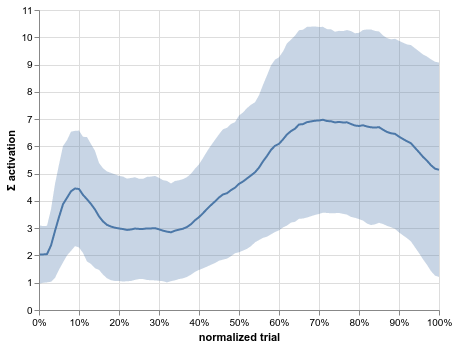

In [20]:
(mu + sigma)  # + c.encode(alt.Color("effect"))

In [21]:
from scipy.signal import find_peaks

t = sum_act.groupby("index")["value"].agg(["mean", "std"])
p, _ = find_peaks(t["mean"], distance=50)
# t.iloc[p, :].multiply(100).round()
t.iloc[p, :].round()

,mean,std
index,,
0.09,4.0,2.0
0.71,7.0,3.0


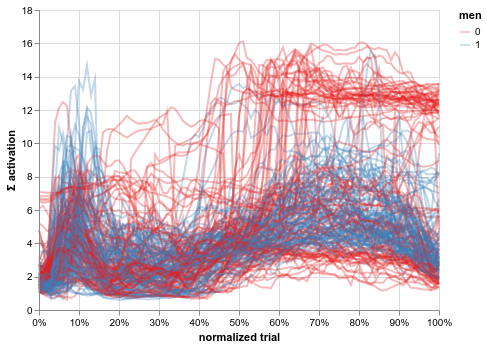

In [22]:
mu.mark_line(opacity=0.3).encode(
    alt.Color("men:N", scale=men_scale), alt.Detail("filename"), alt.Tooltip("filename")
)

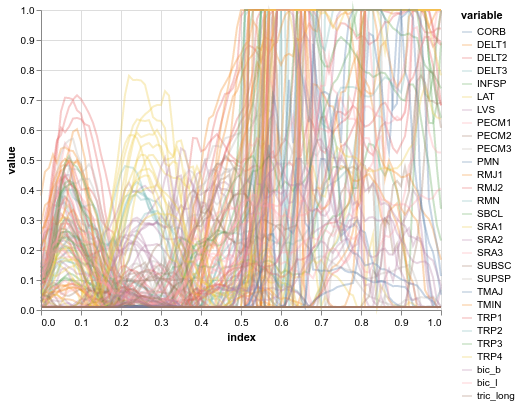

In [23]:
alt.Chart(act_melt.query('participant == "verc"')).mark_line(opacity=0.3).encode(
    alt.X("index:Q"),
    alt.Y("value:Q"),
    alt.Color("variable:N"),
    alt.Detail("filename"),
    alt.Tooltip("variable"),
)

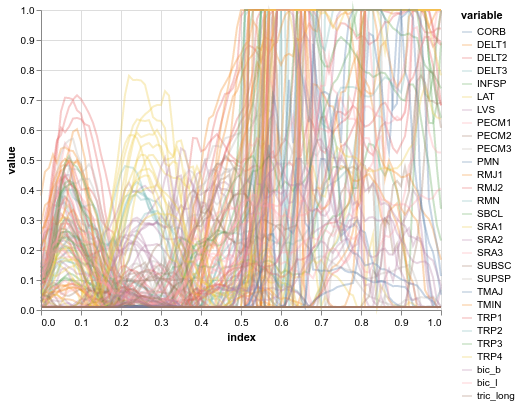

In [24]:
alt.Chart(act_melt.query('participant == "verc"')).mark_line(opacity=0.3).encode(
    alt.X("index:Q"),
    alt.Y("value:Q"),
    alt.Color("variable:N"),
    alt.Detail("filename"),
    alt.Tooltip("variable"),
)

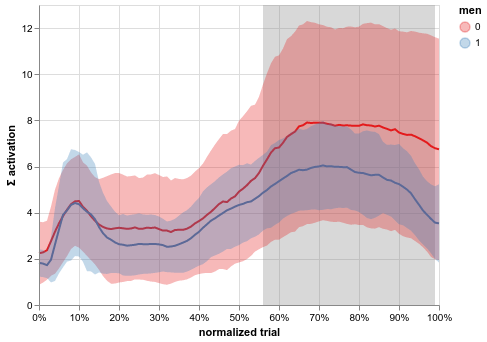

In [25]:
c.transform_filter('datum.effect == "main sex"') + (mu + sigma).encode(
    alt.Color("men:N", scale=men_scale)
)

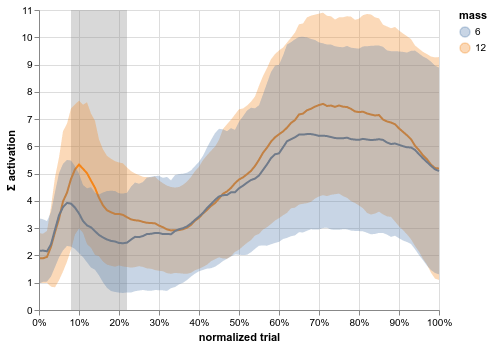

In [26]:
c.transform_filter('datum.effect == "main mass"') + (mu + sigma).encode(
    alt.Color("mass:N")
)

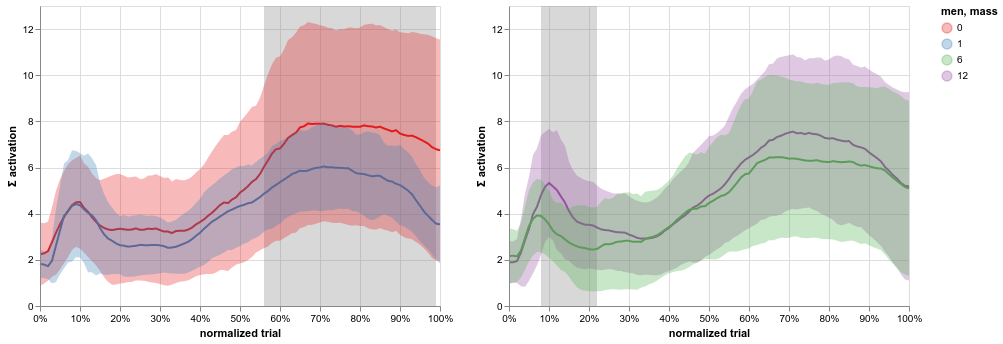

In [27]:
(
    c.transform_filter('datum.effect == "main sex"')
    + (mu + sigma).encode(alt.Color("men:N", scale=men_scale))
    | c.transform_filter('datum.effect == "main mass"')
    + (mu + sigma).encode(alt.Color("mass:N"))
).resolve_scale(x="shared", y="shared")

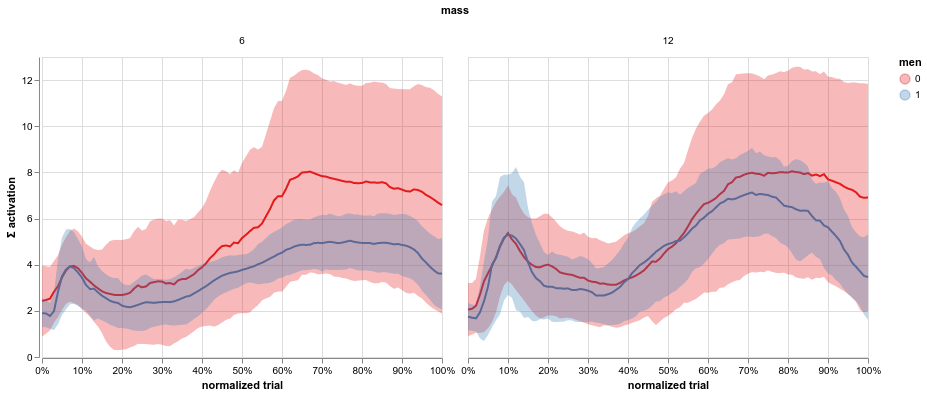

In [28]:
(mu + sigma).encode(alt.Color("men:N", scale=men_scale)).facet(column="mass")

## ECDF

### ECDF on activations

In [29]:
act_melt["ecdf"] = act_melt.groupby("filename")["value"].transform(
    lambda x: x.rank(method="first") / x.shape[0]
)

In [30]:
target_col_shape = 100

y = (
    act_melt.drop(["index", "variable"], axis=1)
    .assign(participant=lambda x: x["participant"].astype("category").cat.codes)
    .set_index([i if i != "index" else "ecdf" for i in id_vars])
    .unstack()
)
y = y.iloc[:, 0 :: int(y.shape[1] / target_col_shape)]
y.head()

value                    \
ecdf                                            0.000341 0.010242 0.020143   
filename    participant men height mass n_trial                              
VerCF12H2_3 34          0   2      12   3           0.01     0.01     0.01   
VerCF12H2_1 34          0   2      12   1           0.01     0.01     0.01   
VerCF6H2_2  34          0   2      6    2           0.01     0.01     0.01   
VerCF6H2_3  34          0   2      6    3           0.01     0.01     0.01   
VerCF12H2_2 34          0   2      12   2           0.01     0.01     0.01   

                                                                            \
ecdf                                            0.030044 0.039945 0.049846   
filename    participant men height mass n_trial                              
VerCF12H2_3 34          0   2      12   3           0.01     0.01     0.01   
VerCF12H2_1 34          0   2      12   1           0.01     0.01     0.01   
VerCF6H2_2  34          0   2      6    2           0.01     0.01     0.01   
VerCF6H2_3  34          0   2      6    3           0.01     0.01     0.01   
VerCF12H2_2 34          0   2      12   2           0.01     0.01     0.01   

                                                                             \
ecdf                                            0.059747 0.069648  0.079549   
filename    participant men height mass n_trial                               
VerCF12H2_3 34          0   2      12   3           0.01     0.01  0.010000   
VerCF12H2_1 34          0   2      12   1           0.01     0.01  0.010000   
VerCF6H2_2  34          0   2      6    2           0.01     0.01  0.010000   
VerCF6H2_3  34          0   2      6    3           0.01     0.01  0.010000   
VerCF12H2_2 34          0   2      12   2           0.01     0.01  0.010001   

                                                           ...            \
ecdf                                             0.089450  ...  0.901332   
filename    participant men height mass n_trial            ...             
VerCF12H2_3 34          0   2      12   3        0.010000  ...  1.000000   
VerCF12H2_1 34          0   2      12   1        0.010000  ...  1.000000   
VerCF6H2_2  34          0   2      6    2        0.010001  ...  0.978812   
VerCF6H2_3  34          0   2      6    3        0.010000  ...  1.000000   
VerCF12H2_2 34          0   2      12   2        0.010001  ...  0.833537   

                                                                              \
ecdf                                             0.911233  0.921133 0.931034   
filename    participant men height mass n_trial                                
VerCF12H2_3 34          0   2      12   3        1.000000  1.000000      1.0   
VerCF12H2_1 34          0   2      12   1        1.000000  1.000000      1.0   
VerCF6H2_2  34          0   2      6    2        0.999985  0.999998      1.0   
VerCF6H2_3  34          0   2      6    3        1.000000  1.000000      1.0   
VerCF12H2_2 34          0   2      12   2        0.954854  0.999997      1.0   

                                                                            \
ecdf                                            0.940935 0.950836 0.960737   
filename    participant men height mass n_trial                              
VerCF12H2_3 34          0   2      12   3            1.0      1.0      1.0   
VerCF12H2_1 34          0   2      12   1            1.0      1.0      1.0   
VerCF6H2_2  34          0   2      6    2            1.0      1.0      1.0   
VerCF6H2_3  34          0   2      6    3            1.0      1.0      1.0   
VerCF12H2_2 34          0   2      12   2            1.0      1.0      1.0   

                                                                            
ecdf                                            0.970638 0.980539 0.990440  
filename    participant men height mass n_trial                             
VerCF12H2_3 34          0   2      12   3            1.0      

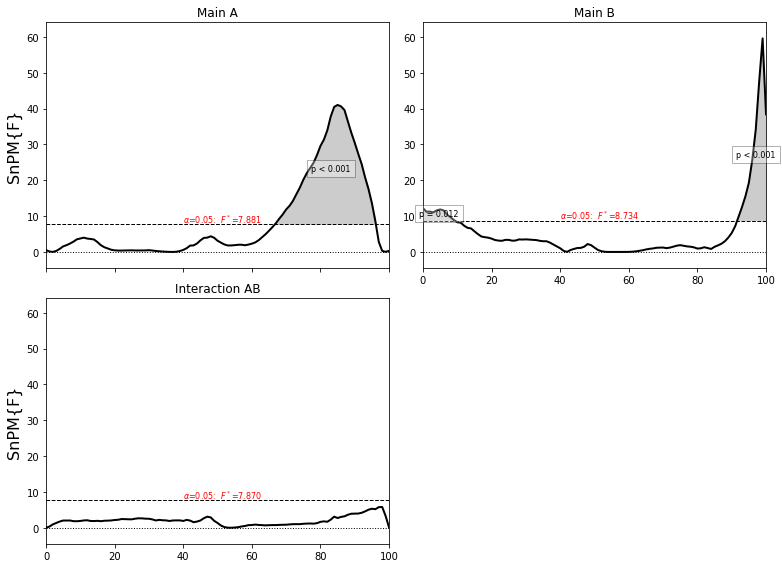

In [31]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    y.to_numpy(), A=y.index.get_level_values("men"), B=y.index.get_level_values("mass")
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [32]:
clusters = get_spm_cluster(
    spmi,
    labels={
        "Main A": "main sex",
        "Main B": "main mass",
        "Interaction AB": "interaction sex-mass",
    },
    mult=1 / y.shape[1],
)
clusters

,effect,p,start,end
0,main sex,0,0.662227,0.951725
1,main mass,0.0123333,0,0.0919826
2,main mass,0,0.906799,0.990099


In [33]:
ecdf = y.stack().reset_index()
clusters = describe_clusters(clusters, ecdf.rename(columns=dict(ecdf="index")), effect)
clusters

,effect,p,start,end,diff desc,mean diff,cohen d,cohen effect
0,main sex,0.000000,0.66,0.95,0 - 1,0.13,0.51,medium
1,main mass,0.012333,0.00,0.09,12 - 6,0.00,0.38,small
2,main mass,0.000000,0.91,0.99,12 - 6,-0.13,-0.58,medium


In [34]:
c = (
    alt.Chart(clusters)
    .mark_rect(opacity=0.3, color="grey")
    .encode(alt.X("start"), alt.X2("end"))
)

In [35]:
base = alt.Chart(ecdf).encode(alt.X("ecdf", axis=alt.Axis(format="%"), title="ecdf"))
mu = base.mark_line().encode(alt.Y("mean(value)", title="activation"))
sigma = base.mark_errorband(extent="stdev").encode(alt.Y("value", title=None))

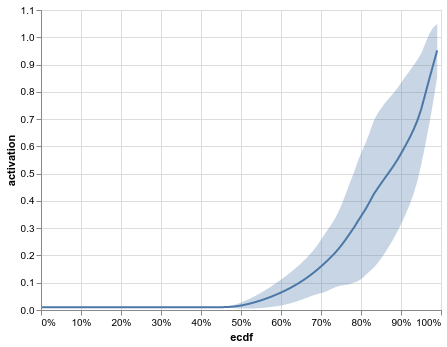

In [36]:
(mu + sigma)  # + c.encode(alt.Color("effect"))

In [37]:
print(ecdf.query("ecdf < 0.5")["value"].agg(["mean", "std"]).multiply(100))
print(ecdf.query("ecdf > 0.5")["value"].agg(["mean", "std"]).multiply(100))

mean    1.024613
std     0.203355
Name: value, dtype: float64
mean    31.446368
std     31.329860
Name: value, dtype: float64


In [38]:
value = [0.6, 0.8, 1]
# index = (df['values'] - value).abs().idxmin()
x = ecdf.groupby("ecdf")["value"].agg(["mean", "std"]).reset_index()

[x.iloc[x["ecdf"].sub(i).abs().idxmin()].multiply(100).round() for i in value]

[ecdf    60.0
 mean     7.0
 std      5.0
 Name: 61, dtype: float64, ecdf    80.0
 mean    35.0
 std     23.0
 Name: 81, dtype: float64, ecdf    99.0
 mean    95.0
 std     10.0
 Name: 100, dtype: float64]

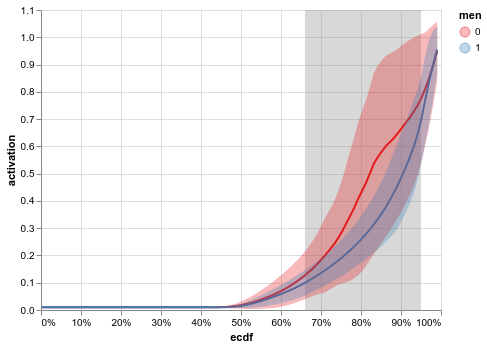

In [39]:
c.transform_filter('datum.effect == "main sex"') + (mu + sigma).encode(
    alt.Color("men:N", scale=men_scale)
)

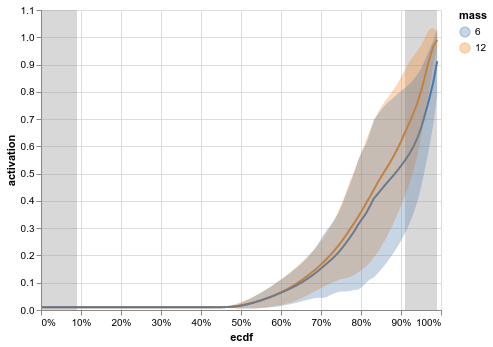

In [40]:
c.transform_filter('datum.effect == "main mass"') + (mu + sigma).encode(
    alt.Color("mass:N")
)

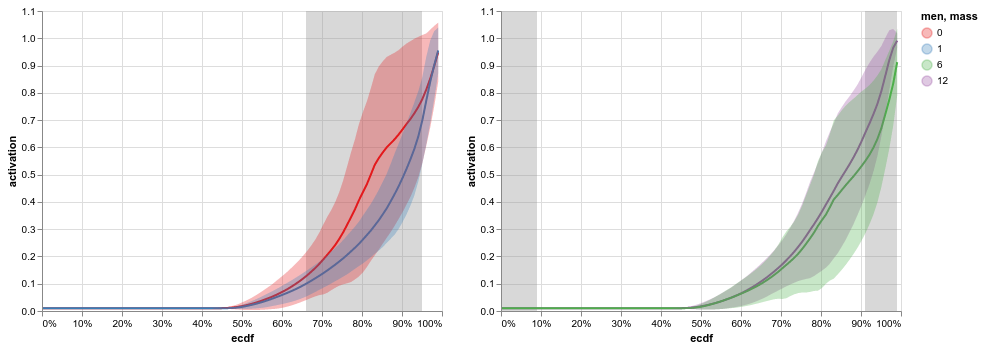

In [41]:
(
    c.transform_filter('datum.effect == "main sex"')
    + (mu + sigma).encode(alt.Color("men:N", scale=men_scale))
    | c.transform_filter('datum.effect == "main mass"')
    + (mu + sigma).encode(alt.Color("mass:N"))
).resolve_scale(x="shared", y="shared")

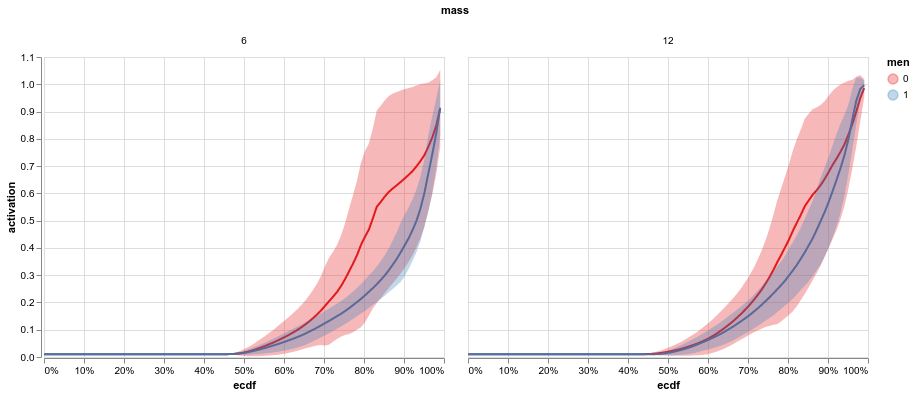

In [42]:
(mu + sigma).encode(alt.Color("men:N", scale=men_scale)).facet(column="mass")

## $\sum\sum\text{activations}$

In [38]:
sum_sum_act = (
    sum_act.groupby([i for i in id_vars if i != "index"])["value"].sum().reset_index()
)
sum_sum_act.head()

,filename,participant,men,height,mass,n_trial,value
0,AimQF12H2_1,aimq,0,2,12,1,150400.072240
1,AimQF12H2_2,aimq,0,2,12,2,141248.853327
2,AimQF12H2_3,aimq,0,2,12,3,134371.847651
3,AimQF6H2_1,aimq,0,2,6,1,143006.493601
4,AimQF6H2_2,aimq,0,2,6,2,210778.534066


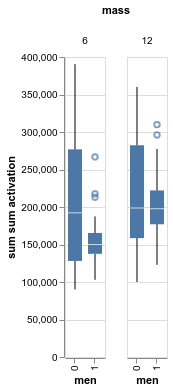

In [39]:
alt.Chart().mark_boxplot().encode(
    alt.X("men:N"), alt.Y("value", title="sum sum activation")
).facet(data=sum_sum_act, column=alt.Column("mass"))

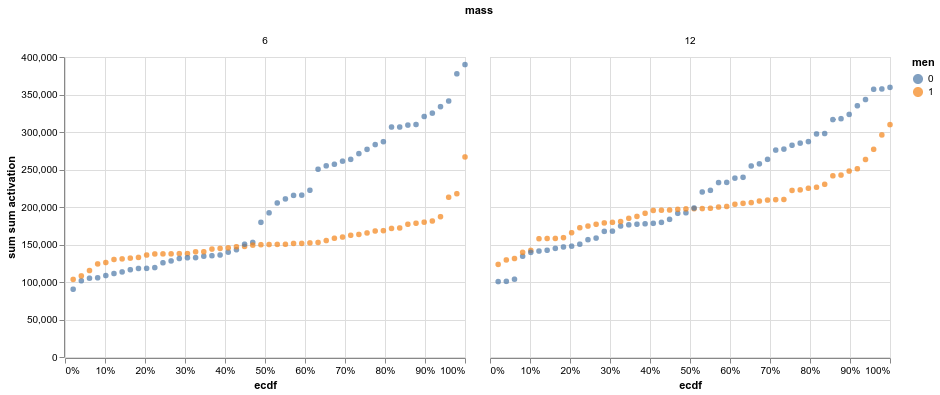

In [40]:
alt.Chart(
    sum_sum_act.assign(
        ecdf=lambda x: x.groupby(["men", "mass"])["value"].transform(
            lambda x: x.rank(method="first") / x.shape[0]
        )
    )
).mark_circle().encode(
    alt.X("ecdf", axis=alt.Axis(format="%")),
    alt.Y("value", title="sum sum activation"),
    alt.Color("men:N"),
    alt.Column("mass"),
)

<!--NAVIGATION-->
< [Analyses](02.00-men-women.ipynb) | [Contents](Index.ipynb) | [Joint reactions](02.02-joint-reactions.ipynb) >